<font size=8> Network Tests


In [ ]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product

#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio



<font size=7> Manual Tuning


In [3]:
[board,profile_path,number_of_chips]=obtain_board()

In [4]:

neuron_config = neuron_configs_bio.config()

neuron_config['PC_Adaptation'] = True
neuron_config['duration'] = 15
neuron_config['input_type'] = 'Regular'
neuron_config['in_freq'] = 20
neuron_config['nvn'] = 15
neuron_config['pcn'] = 100
neuron_config['pvn'] = 20
neuron_config['sstn'] = 15

@timeout_decorator.timeout(50)  # Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
        
    )


In [5]:

#create grid search parameters
param_grid = {
    'SST_W0': product([2,3],[10,50,100,200]),
    'SST_AMPA_GAIN': product([2,3], [10,100,150,200]),
    'SST_AMPA_TAU': product([0],[10,20,40,60]), #80-120
    'SST_LEAK': product([1], [40,20]),# 10-30
    'Input_SST': [.05, .1,.2],
    'PC_SST': [.05, .1,.2]
}

# STD 
# Flatten the product for the parameters
expanded_param_grid = {
    key: list(value) for key, value in param_grid.items()
}

param_values = list(expanded_param_grid.values())
total_combinations = len(list(product(*param_values))) # Total number of parameter combinations


# Load previous unique results to skip simulations that have already been run
try:
    with open('results_grid_1.pkl', 'rb') as f:
        results = pickle.load(f)
    unique_params_set = set(tuple(entry[0].items()) for entry in results)
except FileNotFoundError:
    unique_params_set = set()

start_time = time.time()  # Record the start time

# Iterate through the parameter grid 
for i, params in enumerate(product(*param_values), start=0):

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    
    if elapsed_time > 21600:  # 21600 seconds == 6 hours
        print("6 hours have passed. Ending the simulation.")
        break  # Break out of the loop

    print(f"Running simulation {i+1}/{total_combinations}...")

    # Create a dictionary of the current parameter values, flattening product objects
    current_params = {
        key: (item[0], item[1]) if isinstance(item, tuple) else item
        for key, item in zip(expanded_param_grid.keys(), params)
    }

    # Skip this simulation if its parameters have already been run
    if tuple(current_params.items()) in unique_params_set:
        print(f"Skipping simulation {i+1}/{total_combinations} as it has already been run.")
        continue

    
    # Update the values in neuron_config with the current parameter values
    neuron_config.update(current_params)
    print('current parameters')
    try:
        [output_events, test_config] = run_simulation(neuron_config)
        fot_output= frequency_over_time(test_config, output_events)
        time_stamp=test_config['date_label']+'-'+test_config['time_label']

        [time_axis, ff_windows_pc, ff_windows_pv, ff_windows_sst] = fot_output
        fvt_fig = frequency_vs_time_plot(frequency_over_time(test_config, output_events), test_config, save=True, annotate=True,neuron_config=neuron_config)
        slope = calculate_slope(time_axis, ff_windows_sst)
        results.append((current_params, slope,time_stamp))  # Storing the current_params instead of neuron_config
        # Save Progress
        with open('results_grid_1.pkl', 'wb') as f:
            pickle.dump(results, f)
    except timeout_decorator.TimeoutError:
        results.append((current_params, 'N/A','N/A'))  # Storing the current_params instead of neuron_config
        # Save progress
        with open('results_grid_1.pkl', 'wb') as f:
            pickle.dump(results, f)
        print("Simulation timed out, trying again with new parameters...")

print("Simulation completed")



Running simulation 1/4608...
Skipping simulation 1/4608 as it has already been run.
Running simulation 2/4608...
Skipping simulation 2/4608 as it has already been run.
Running simulation 3/4608...
Skipping simulation 3/4608 as it has already been run.
Running simulation 4/4608...
Skipping simulation 4/4608 as it has already been run.
Running simulation 5/4608...
Skipping simulation 5/4608 as it has already been run.
Running simulation 6/4608...
Skipping simulation 6/4608 as it has already been run.
Running simulation 7/4608...
Skipping simulation 7/4608 as it has already been run.
Running simulation 8/4608...
Skipping simulation 8/4608 as it has already been run.
Running simulation 9/4608...
Skipping simulation 9/4608 as it has already been run.
Running simulation 10/4608...
Skipping simulation 10/4608 as it has already been run.
Running simulation 11/4608...
Skipping simulation 11/4608 as it has already been run.
Running simulation 12/4608...
Skipping simulation 12/4608 as it has alre

In [7]:
print(results[-1])

({'SST_W0': (2, 10), 'SST_AMPA_GAIN': (2, 150), 'SST_AMPA_TAU': (0, 40), 'SST_LEAK': (1, 40), 'Input_SST': 0.1, 'PC_SST': 0.1}, 0.10994346556560718, '2023-08-31-10-15')


In [8]:
import pandas as pd
import pickle

# Load previous results if available
try:
    with open('results_grid_1.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = []
print(results)

# Convert to DataFrame
df = pd.DataFrame([dict(entry[0], **{'Result': entry[1], 'Timestamp': entry[2]}) for entry in results])

# Save to Excel
df.to_excel("results_1_chart_with_timestamp.xlsx", index=False)


[({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.05, 'PC_SST': 0.05}, 0.0, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.05, 'PC_SST': 0.1}, 0.003249654724185557, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.05, 'PC_SST': 0.2}, 0.010408452925406094, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.1, 'PC_SST': 0.05}, 0.0, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.1, 'PC_SST': 0.1}, 0.0, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_GAIN': (2, 10), 'SST_AMPA_TAU': (1, 10), 'SST_LEAK': (0, 10), 'Input_SST': 0.1, 'PC_SST': 0.2}, 0.005820705079497074, '0000-00-00-00-0'), ({'SST_W0': (3, 10), 'SST_AMPA_

ValueError: not enough values to unpack (expected 2, got 0)

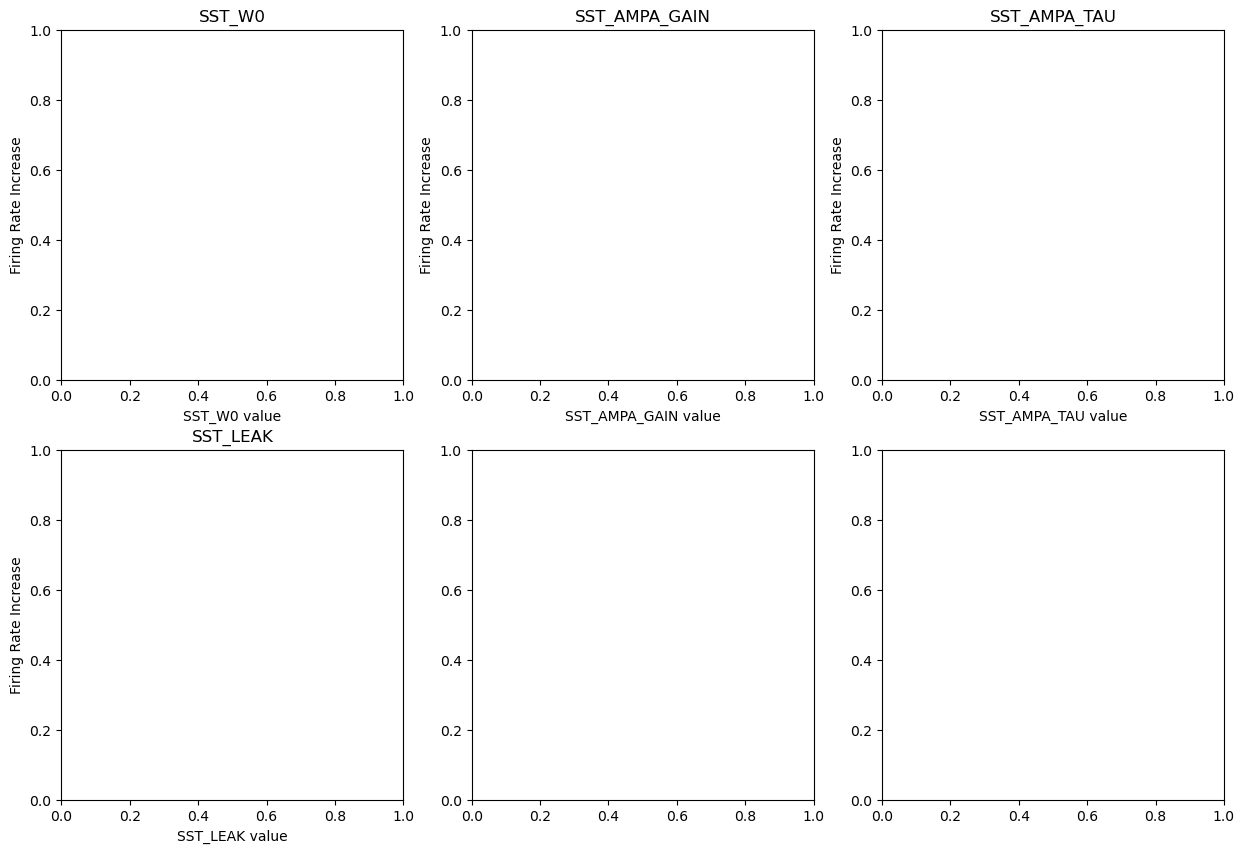

In [3]:
import matplotlib.pyplot as plt
import pickle

try:
    with open('results_1.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    results = []
# Parameters for which you want to create subplots
parameters = ['SST_W0', 'SST_AMPA_GAIN', 'SST_AMPA_TAU', 'SST_LEAK', 'Input_SST', 'PC_SST']

# Define the number of subplots (2 rows and 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Define marker shapes
markers = ['o', 's', 'v', '^', '<', '>']

# Iterate through each parameter and create subplots
for i, param in enumerate(parameters):
    # If the parameter is not from the first four, there's no coarse value
    if param in ['SST_W0', 'SST_AMPA_GAIN', 'SST_AMPA_TAU', 'SST_LEAK']:
        unique_coarse_values = set([r[0][param][0] for r in results if param in r[0]])

        for j, coarse_value in enumerate(unique_coarse_values):
            # Filter the results for the current coarse value
            filtered_results = [(r[0][param][1], r[1]) for r in results if param in r[0] and r[0][param][0] == coarse_value]

            # Separate the fine values and the slopes
            fine_values, slopes = zip(*filtered_results)

            # Plot the data using different marker shapes for each coarse value
            axes[i].scatter(fine_values, slopes, label=f'Coarse value: {coarse_value}', marker=markers[j % len(markers)])
    else:
        # If the parameter is 'input_sst' or 'pc_sst', plot them directly
        values, slopes = zip(*[(r[0][param], r[1]) for r in results if param in r[0]])

        # Plot the data
        axes[i].scatter(values, slopes)

    axes[i].set_title(f'{param.upper()}')
    axes[i].set_xlabel(f'{param} value')
    axes[i].set_ylabel('Firing Rate Increase')

    # Add a legend to distinguish between different coarse values
    if param in ['sst_w0', 'sst_ampa_gain', 'sst_ampa_tau', 'sst_leak']:
        axes[i].legend()

plt.tight_layout()
plt.show()
